## 1. Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#extract zip folder
!unzip '/content/drive/My Drive/Northwestern MS/453 - Natural Language Processing/Project/UNGDC19702018.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Converted sessions/Session 63 - 2008/PHL_63_2008.txt  
  inflating: __MACOSX/Converted sessions/Session 63 - 2008/._PHL_63_2008.txt  
  inflating: Converted sessions/Session 63 - 2008/DZA_63_2008.txt  
  inflating: __MACOSX/Converted sessions/Session 63 - 2008/._DZA_63_2008.txt  
  inflating: Converted sessions/Session 63 - 2008/MEX_63_2008.txt  
  inflating: __MACOSX/Converted sessions/Session 63 - 2008/._MEX_63_2008.txt  
  inflating: Converted sessions/Session 63 - 2008/AUT_63_2008.txt  
  inflating: __MACOSX/Converted sessions/Session 63 - 2008/._AUT_63_2008.txt  
  inflating: Converted sessions/Session 63 - 2008/COG_63_2008.txt  
  inflating: __MACOSX/Converted sessions/Session 63 - 2008/._COG_63_2008.txt  
  inflating: Converted sessions/Session 63 - 2008/CYP_63_2008.txt  
  inflating: __MACOSX/Converted sessions/Session 63 - 2008/._CYP_63_2008.txt  
  inflating: Converted sessions/Session 63 - 2008/SLB_63_2008.txt  

In [3]:
# Path to the folder containing sessions
base_path = 'Converted sessions/'

In [4]:
# Import Libraries
import glob
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
from wordcloud import WordCloud

## 2. Preprocessing

In [5]:
# function to clean text
def clean(text):
      # removing paragraph numbers
      text = re.sub('[0-9]+.\t', '', text)
      # removing new line characters
      text = re.sub('\n', '', text)
      text = re.sub('\n', ' ', text)
      # remove apostrophes
      text = re.sub("'s", '', text)
      # replacing hyphen with blank space
      text = re.sub('-', ' ', text)
      text = re.sub('- ', '', text)
      # remove quotation marks
      text = re.sub('\"', '', text)
      # removing slautations
      text = re.sub('Mr\.', 'Mr', text)
      text = re.sub('Mrs\.', 'Mrs', text)
      text = re.sub('Ms\.', 'Ms', text)
      text = re.sub('Dr\.', 'Dr', text)
      # remove whitespaces
      text = text.strip()
      #removing reference to outside text
      text = re.sub('[\(\[].*?[\)\])]', '', text)
      # removing extra spaces
      text = re.sub(' +', ' ', text)
      return text

In [6]:
# function to split text into sentences
def sentences(text):
      text = re.split('[.?!]', text)
      clean_sent = []
      for sent in text:
        if sent != '':
          clean_sent.append(sent)
      return clean_sent

## 3. Topic Extraction Using **Latent Dirichlet Allocation** (LDA)

In [7]:
# Function to extract 5 topics from every speech
def extract_topics_single(speech, num_topics=1, num_words=5):
    vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words='english')
    X = vectorizer.fit_transform([speech])  # Wrapping speech in a list to ensure compatibility
    lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=50, random_state=None)
    lda_model.fit(X)
    topics = lda_model.components_

    topic_list = []
    for topic_idx, topic in enumerate(topics):
        top_indices = topic.argsort()[-num_words:][::-1]  # Indices of top words
        top_features = [vectorizer.get_feature_names_out()[i] for i in top_indices]
        topic_list.append(", ".join(top_features))  # Append each topic as a string

    return topic_list  # Return topics as a list of strings

In [8]:
# Create a dataframe by consolidating all the information from the files
data = []
base_path = 'Converted sessions/'
for session_folder in sorted(glob.glob(base_path + 'Session*')):
    session = session_folder.split('/')[-1]
    year = session.split()[-1]
    if 1971 <= int(year) <= 2018:
        for file_path in glob.glob(session_folder + '/*.txt'):
            country_code = os.path.basename(file_path).split('_')[0]
            with open(file_path, 'r', encoding='utf-8') as file:
                speech = file.read()
                cleaned_speech = clean(speech)
                cleaned_sentences = sentences(cleaned_speech)
                combined_speech = " ".join(cleaned_speech) if isinstance(cleaned_speech, list) else cleaned_speech
                topics = extract_topics_single(combined_speech)  # Extract topics for each speech
            data.append({
                'Country': country_code,
                'Session': session,
                'Year': year,
                'Speech': cleaned_sentences,
                'Topics': topics  # Topics stored as a list
            })

df = pd.DataFrame(data)

## 4. Data Exploration

In [9]:
df.shape

(8023, 5)

In [10]:
df.head()

,Country,Session,Year,Speech,Topics
0,ZAF,Session 26 - 1971,1971,"[Mr President, I am glad to have the opportuni...","[africa, south, african, south africa, governm..."
1,ECU,Session 26 - 1971,1971,[The Government of Ecuador wishes to extend co...,"[international, peace, nations, world, ecuador]"
2,MNG,Session 26 - 1971,1971,"[Mr President, may I, on behalf of the delegat...","[united, republic, peace, united nations, nati..."
3,GUY,Session 26 - 1971,1971,"[Mr, President, may I join with all those who ...","[international, organization, world, assembly,..."
4,ISL,Session 26 - 1971,1971,"[Mr President, at the outset of my statement I...","[nations, united, united nations, general, int..."


In [11]:
df.Speech[67]

['I should like, Sir, on behalf of the Irish delegation, to add my warm congratulations on your election as President of the twenty sixth session of the General Assembly',
 ' The Assembly has chosen a President who knows how to bear wisdom lightly and, in electing you to this high honor, has paid tribute to you as a distinguished leader and statesman of your great country, a country of rich cultural diversity in unity and one which has such an important role in the affairs of your region and among all the nations',
 'I am happy to join in the universal tribute that has also been paid to',
 ' Mr Hambro, the distinguished representative of Norway, whose patience, skill and dynamism were so brilliantly displayed as President of the twenty fifth session of the Assembly',
 '113',
 ' It is my pleasant duty to join in welcoming three new Member States, Bhutan, Bahrain and Qatar, Together they are further encouraging evidence of the spirit of freedom which has animated this Assembly from its b

In [12]:
df.Topics[67]

['ireland, peace, united, political, northern']

In [13]:
# create df['Word Count']
df['Word Count'] = df['Speech'].apply(lambda x: len(str(x).split()))

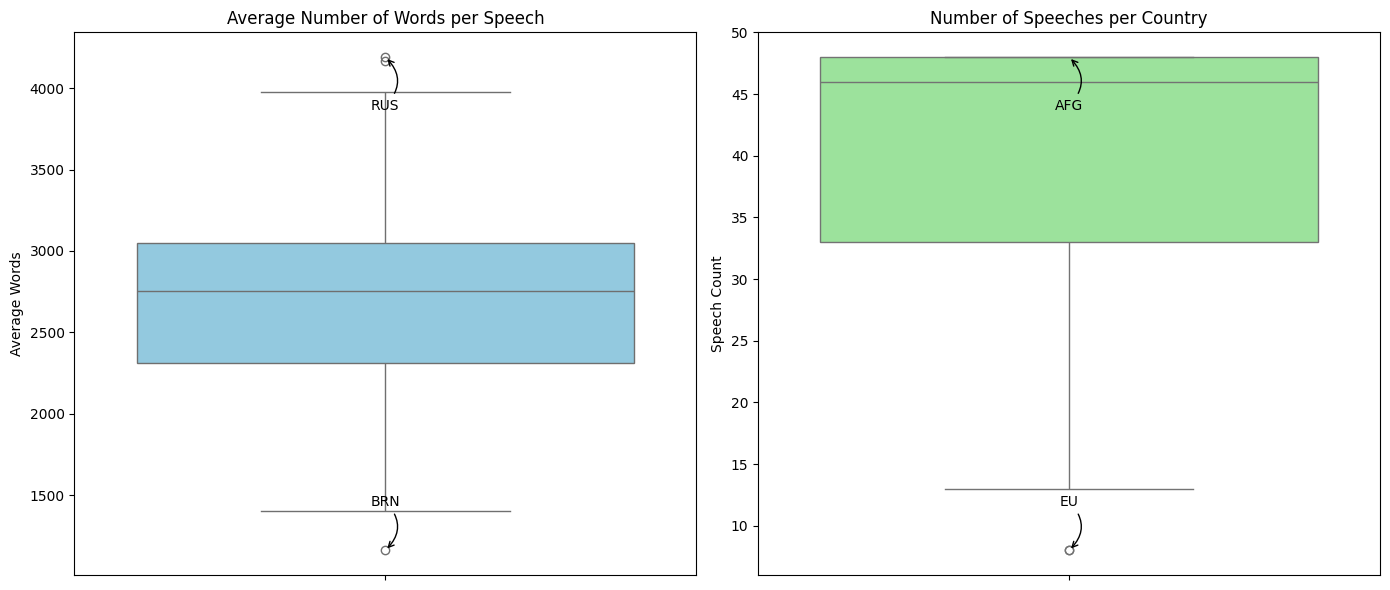

In [14]:
# Calculate average words per speech by country
avg_words_per_speech = df.groupby('Country')['Word Count'].mean()

# Calculate the number of speeches per country
speeches_per_country = df.groupby('Country').size()

# Create a figure for the plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for Average Number of Words per Speech
sns.boxplot(y=avg_words_per_speech, ax=ax[0], color='skyblue')
ax[0].set_title('Average Number of Words per Speech')
ax[0].set_ylabel('Average Words')

# Find and annotate the country with the max and min average words
max_words_country = avg_words_per_speech.idxmax()
min_words_country = avg_words_per_speech.idxmin()
ax[0].annotate(max_words_country,
               xy=(0, avg_words_per_speech[max_words_country]),
               xytext=(0, -40),
               textcoords='offset points',
               arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"),
               ha='center', va='bottom')
ax[0].annotate(min_words_country,
               xy=(0, avg_words_per_speech[min_words_country]),
               xytext=(0, 40),
               textcoords='offset points',
               arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.5"),
               ha='center', va='top')

# Boxplot for Number of Speeches per Country
sns.boxplot(y=speeches_per_country, ax=ax[1], color='lightgreen')
ax[1].set_title('Number of Speeches per Country')
ax[1].set_ylabel('Speech Count')

# Find and annotate the country with the max and min number of speeches
max_speeches_country = speeches_per_country.idxmax()
min_speeches_country = speeches_per_country.idxmin()
ax[1].annotate(max_speeches_country,
               xy=(0, speeches_per_country[max_speeches_country]),
               xytext=(0, -40),
               textcoords='offset points',
               arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"),
               ha='center', va='bottom')
ax[1].annotate(min_speeches_country,
               xy=(0, speeches_per_country[min_speeches_country]),
               xytext=(0, 40),
               textcoords='offset points',
               arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.5"),
               ha='center', va='top')

# Improve layout and display the plot
plt.tight_layout()
plt.show()


In [15]:
pd.to_pickle(df, 'df_with_topics.pkl')

In [16]:
df = pd.read_pickle('df_with_topics.pkl')

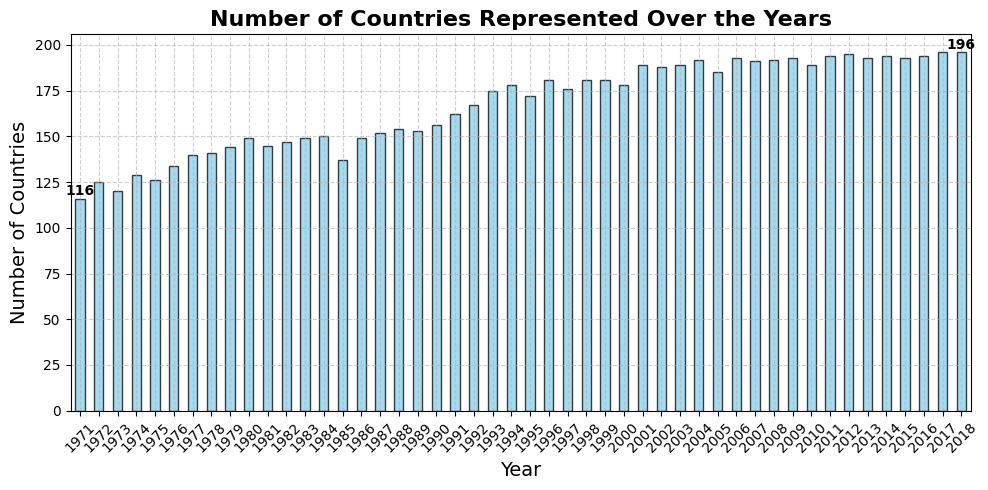

In [17]:
# Group by 'Year' and count unique 'Country' entries
country_counts_per_year = df.groupby('Year')['Country'].nunique()

# Plot the results
plt.figure(figsize=(10, 5))  # Increased size for better readability
ax = country_counts_per_year.plot(kind='bar', color='skyblue', alpha=0.75, edgecolor='black')
plt.title('Number of Countries Represented Over the Years', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Countries', fontsize=14)
plt.xticks(rotation=45)  # Rotate the x labels to make them more readable
plt.grid(True, linestyle='--', alpha=0.6)  # Make grid less pronounced
plt.tight_layout()  # Adjusts plot parameters to give some padding

# Add data labels to the first and the last bar
y_offset = 2  # Offset for label placement above the bar
for i, label in enumerate(list(country_counts_per_year.index)):
    count = country_counts_per_year[label]
    if i == 0 or i == len(country_counts_per_year) - 1:  # Check for first or last bar
        ax.text(i, count + y_offset, f'{count}', ha='center', color='black', fontweight='bold')

plt.show()


In [18]:
# Flatten the list of topics from each sublist directly, and split each topic by commas
individual_terms = [term.strip() for sublist in df['Topics'] for topic in sublist for term in topic.split(', ')]

# Count the frequencies of each individual term
term_counts = Counter(individual_terms)

# Sort the terms by frequency in descending order
sorted_terms = dict(sorted(term_counts.items(), key=lambda item: item[1], reverse=True))


In [19]:
# Print the top 25 most frequent topics
top_25_topics = list(sorted_terms.items())[:25]
print("LDA: Top 25 Most Frequent Topics:\n")
for topic, count in top_25_topics:
    print(f"{topic}: {count}")


LDA: Top 25 Most Frequent Topics:

nations: 4562
united: 4045
international: 3528
world: 2487
united nations: 2435
countries: 2042
peace: 1732
development: 1317
people: 1062
security: 820
states: 819
economic: 548
country: 471
africa: 426
government: 359
new: 358
human: 339
general: 317
rights: 287
republic: 259
global: 225
nuclear: 201
south: 185
organization: 179
council: 172


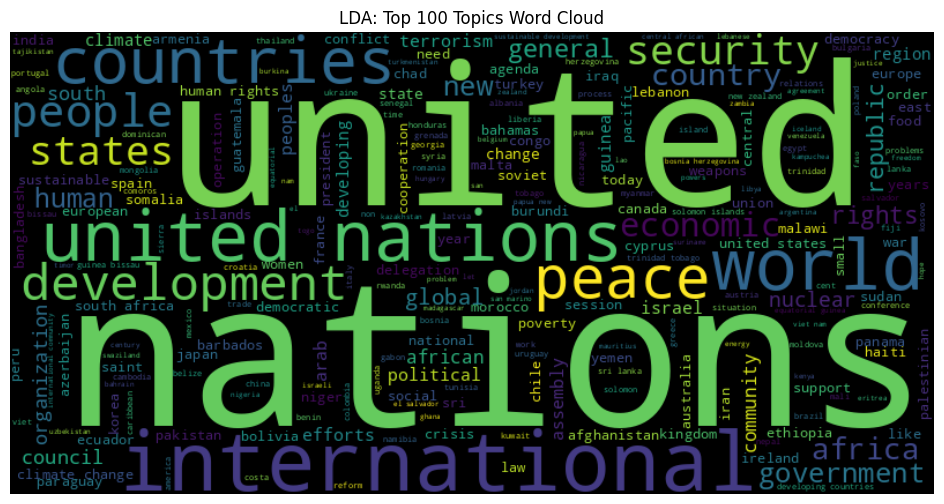

In [20]:
# Create a word cloud from the sorted topic frequencies
wordcloud = WordCloud(width=800, height=400, max_words=250).generate_from_frequencies(sorted_terms)

# Plot the word cloud
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('LDA: Top 100 Topics Word Cloud')
plt.show()


## 5. Clustering

In [21]:
# Aggregate topics by country across all years
aggregated_topics = df.groupby('Country')['Topics'].agg(sum).reset_index()

# Create a new DataFrame with just the 'Country' and 'Topics'
final_df = pd.DataFrame({
    'Country': aggregated_topics['Country'],
    'Topics': aggregated_topics['Topics']
})

# Display the resulting DataFrame
print(final_df.head())

  Country                                             Topics
0     AFG  [nations, united, united nations, world, count...
1     AGO  [people, national, angola, republic, countries...
2     ALB  [states, united, united states, peoples, peopl...
3     AND  [states, small, world, nations, great, nations...
4     ARE  [countries, international, arab, people, peace...


In [22]:
# Convert list of topics to a single string per country
final_df['Topics_Str'] = final_df['Topics'].apply(lambda x: ' '.join(x))

In [23]:
# create tfidf vectors
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(final_df['Topics_Str'])

# Initialize variables to store the best configuration
best_score = -1
best_params = None

# Define a range of parameters
params_grid = {
    'n_clusters': [2, 3, 4, 5],
    'init': ['k-means++', 'random'],
    'n_init': [10, 15, 20]
}

# Apply TF-IDF from previous steps
for k in params_grid['n_clusters']:
    for init_method in params_grid['init']:
        for n_init_val in params_grid['n_init']:
            kmeans = KMeans(n_clusters=k, init=init_method, n_init=n_init_val, random_state=42)
            cluster_labels = kmeans.fit_predict(tfidf_matrix)
            silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)

            # Check if the current configuration is better
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_params = {'n_clusters': k, 'init': init_method, 'n_init': n_init_val}

# Output the best configuration
print("Best Silhouette Score:", best_score)
print("Best Parameters:", best_params)

# Save the best parameters
kmeans_final = KMeans(n_clusters=best_params['n_clusters'], init=best_params['init'], n_init=best_params['n_init'], random_state=42)
clusters = kmeans_final.fit_predict(tfidf_matrix)


Best Silhouette Score: 0.28964131759463224
Best Parameters: {'n_clusters': 2, 'init': 'k-means++', 'n_init': 20}


In [24]:
# Addition of Cluster to the dataframe with best parameters
final_df['Cluster'] = kmeans_final.fit_predict(tfidf_matrix)

# Print the final DataFrame with clusters assigned
print(final_df[['Country', 'Cluster']].head(10))

  Country  Cluster
0     AFG        1
1     AGO        0
2     ALB        0
3     AND        0
4     ARE        1
5     ARG        0
6     ARM        0
7     ATG        0
8     AUS        0
9     AUT        0


In [25]:
dense_tfidf_matrix = tfidf_matrix.todense()
# Convert the dense_tfidf_matrix to a NumPy array
dense_tfidf_array = np.asarray(dense_tfidf_matrix)

# Create a PCA instance with 2 components
pca = PCA(n_components=2)

# Fit the PCA instance to the dense_tfidf_array
reduced_features = pca.fit_transform(dense_tfidf_array)


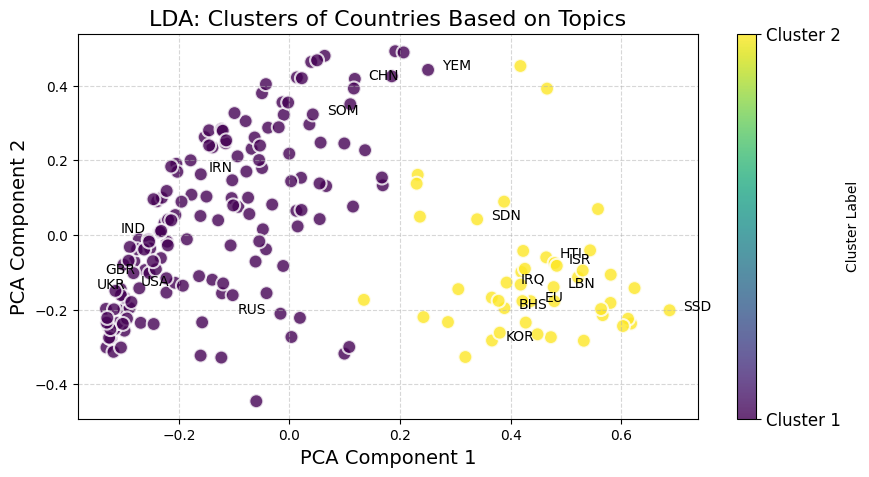

In [26]:
# Function to determine text position to avoid overlap in the plot
def adjust_text_position(x, y, text, ax):
    if x > 0:
        return ax.annotate(text, (x, y), textcoords="offset points", xytext=(10,0), ha='left')
    else:
        return ax.annotate(text, (x, y), textcoords="offset points", xytext=(-10,0), ha='right')

# Create the scatter plot with PCA components
plt.figure(figsize=(10, 5))
# Adjust the number of colors in cmap to match the number of clusters
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', s=100, alpha=0.8, edgecolors='w', linewidths=1.5)
plt.title('LDA: Clusters of Countries Based on Topics', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)
cbar = plt.colorbar(scatter, label='Cluster Label', ticks=range(2))  # Ensure colorbar only shows two ticks
cbar.ax.set_yticklabels(['Cluster 1', 'Cluster 2'])  # Label the clusters
cbar.ax.tick_params(labelsize=12)

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Annotating specific countries with custom positions
for i, country in enumerate(final_df['Country']):
    if country in ['USA', 'RUS', 'CHN', 'KOR', 'EU', 'IRN', 'IRQ', 'HTI', 'BHS', 'IND', 'ISR', 'YEM', 'LBN', 'UKR', 'GBR', 'SSD', 'SDN', 'SOM']:
        adjust_text_position(reduced_features[i, 0], reduced_features[i, 1], country, plt.gca())

plt.show()


In [27]:
# Flatten the list of topics from each sublist directly, and split each topic by commas
individual_terms_cluster_0 = [term.strip() for sublist in final_df[final_df['Cluster'] == 0]['Topics'] for topic in sublist for term in topic.split(', ')]
individual_terms_cluster_1 = [term.strip() for sublist in final_df[final_df['Cluster'] == 1]['Topics'] for topic in sublist for term in topic.split(', ')]

# Convert lists of terms into single strings for word cloud generation
text_cluster_0 = ' '.join(individual_terms_cluster_0)
text_cluster_1 = ' '.join(individual_terms_cluster_1)


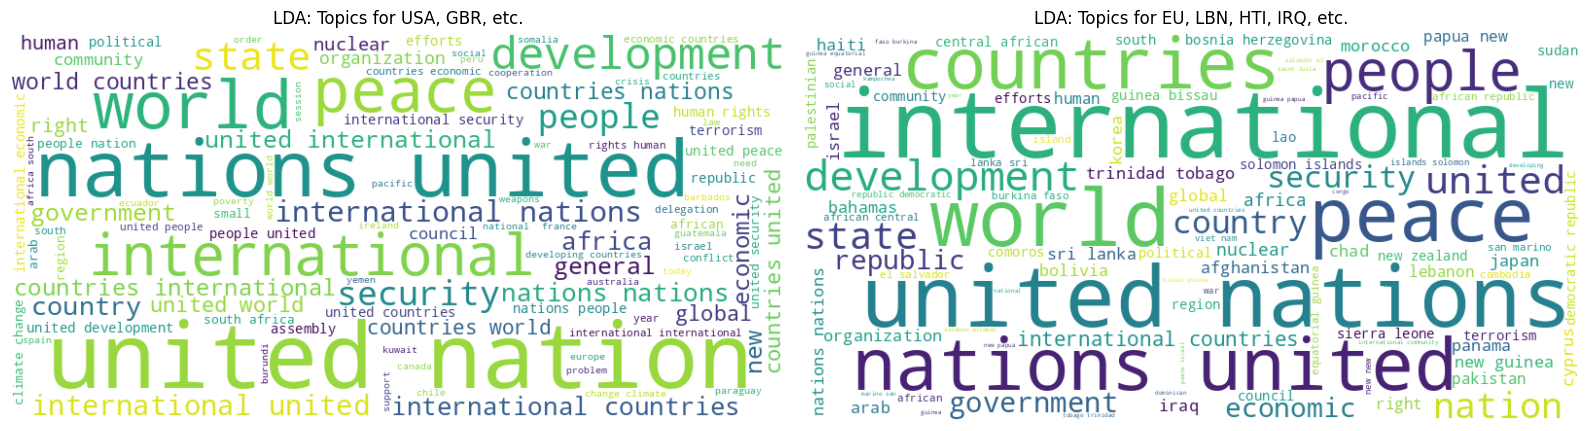

In [28]:
# Function to generate and display word clouds for both clusters side by side
def generate_word_clouds(text_cluster_0, text_cluster_1):
    # Set up the matplotlib figure and subplots
    plt.figure(figsize=(16, 8))  # Overall figure size

    # Subplot for Cluster 0
    ax1 = plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    wordcloud0 = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(text_cluster_0)
    ax1.imshow(wordcloud0, interpolation='bilinear')
    ax1.axis('off')  # No axis for word cloud
    ax1.set_title('LDA: Topics for USA, GBR, etc.')

    # Subplot for Cluster 1
    ax2 = plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    wordcloud1 = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(text_cluster_1)
    ax2.imshow(wordcloud1, interpolation='bilinear')
    ax2.axis('off')  # No axis for word cloud
    ax2.set_title('LDA: Topics for EU, LBN, HTI, IRQ, etc.')

    # Show the plot
    plt.tight_layout()  # Adjusts subplots to give some padding between them
    plt.show()

generate_word_clouds(text_cluster_0, text_cluster_1)


The word clouds represent the most prominent topics discussed in UN General Assembly speeches by two different groups of countries. For the first group, which includes countries like the USA and the UK, key themes highlighted are "international," "security," "development," and "economic." This suggests a focus on global security issues, international cooperation, and economic development.
The second word cloud, representing countries like the EU, Lebanon, Haiti, and Iraq, also emphasizes "international" and "development," but with a stronger presence of words like "peace," "people," and "government." This indicates a significant focus on peace efforts, governance, and human-centric topics in their discussions.
